## Practice notebook for project

### Usefil web resources
1. [sppinaler-neiromophic-classifier](https://github.com/alandiamond/spinnaker-neuromorphic-classifier/blob/master/Spinn5-LargeModel-LiveSpiking/src/python/Classifier_LiveSpikingInput.py)
2. [stdp-mnist](https://github.com/Hananel-Hazan/stdp-mnist/blob/master/code/train/snn_mnist.py)
3. [SNN_from_scratch](http://www.mjrlab.org/wp-content/uploads/2014/05/network_python_tutorial2013.pdf)  
4. [Nengo - pynn wrapper](http://compneuro.uwaterloo.ca/files/publications/bekolay.2014.pdf)
5. [Nengo - paper combining DNN and Nengo](https://arxiv.org/pdf/1805.11144.pdf)
6. [PyNN Official Documentation](http://neuralensemble.org/docs/PyNN/)
7. [Nanfo OCL](https://pypi.org/project/nengo-ocl/)

### Examples with Nango

##### Step 1: Create the network

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import nengo

model = nengo.Network(label='2D Representation')
with model:
    # Our ensemble consists of 100 leaky integrate-and-fire neurons,
    # and represents a 2-dimensional signal
    neurons = nengo.Ensemble(100, dimensions=2)

##### Step 2: Provide input to the model

In [2]:
with model:
    # Create input nodes representing the sine and cosine
    sin = nengo.Node(output=np.sin)
    cos = nengo.Node(output=np.cos)

##### Step 3: Connect the input to the ensemble

In [3]:
with model:
    # The indices in neurons define which dimension the input will project to
    nengo.Connection(sin, neurons[0])
    nengo.Connection(cos, neurons[1])

##### Step 4: Probe outputs
Anything that is probed will collect the data it produces over time, allowing us to analyze and visualize it later. Let’s collect all the data produced.

In [6]:
with model:
    sin_probe = nengo.Probe(sin, 'output')
    cos_probe = nengo.Probe(cos, 'output')
    neurons_probe = nengo.Probe(neurons, 'decoded_output', synapse=0.01)

##### Step 5: Run the model

In [7]:
with nengo.Simulator(model) as sim:
    sim.run(5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

##### Step 6: Plot the model output

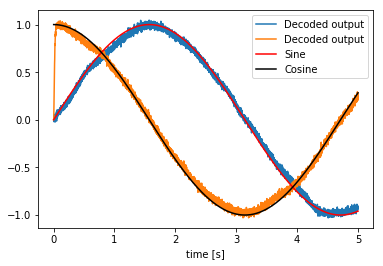

In [8]:
# Plot the decoded output of the ensemble
plt.figure()
plt.plot(sim.trange(), sim.data[neurons_probe], label="Decoded output")
plt.plot(sim.trange(), sim.data[sin_probe], 'r', label="Sine")
plt.plot(sim.trange(), sim.data[cos_probe], 'k', label="Cosine")
plt.legend()
plt.xlabel('time [s]');

------------------------
### MNIST with Nango and Keras
[MNIST classifier with Keras and Nengo](https://www.nengo.ai/nengo-extras/examples/keras/mnist_spiking_cnn.html)

In [9]:
def load_data(filepath):
    return np.loadtxt(filepath, delimiter=',')

#### Load dataset
* MUST channels first!!

In [48]:
x_train = load_data("./TrainDigitX.csv")
y_train = load_data("./TrainDigitY.csv")

print("shape check")
print(x_train.shape, y_train.shape)

shape check
(50000, 784) (50000,)


In [49]:
x_test = load_data("./TestDigitX.csv")
y_test = load_data("./TestDigitY.csv")

print("shape check")
print(x_test.shape, y_test.shape)

shape check
(10000, 784) (10000,)


In [17]:
import os
import nengo_ocl

import keras
from keras.models import Sequential
from keras.layers import Activation, Convolution2D, Dense, Dropout, Flatten
from keras.layers.noise import GaussianNoise
from keras.utils import np_utils

from nengo_extras.keras import (
    load_model_pair, save_model_pair, SequentialNetwork, SoftLIF)
from nengo_extras.gui import image_display_function

#### Preprocess

In [51]:
def preprocess(x, img_rows=28, img_cols=28):
    return x.reshape(x.shape[0], 1, img_rows, img_cols)
x_train, x_test = preprocess(x_train), preprocess(x_test)

In [52]:
y_train.shape

(50000,)

##### Parameters

In [50]:
# --- Parameters
np.random.seed(1)
filename = 'mnist_spiking_cnn'
run_in_theano = False
use_ocl = True
presentation_time = 0.15
n_presentations = 100
n_classes = 10
data_format = 'channels_first'

In [53]:
# --- Train model
if not os.path.exists(filename + '.h5'):
    batch_size = 128
    epochs = 6

    n_filters = 32        # number of convolutional filters to use
    kernel_size = (3, 3)  # shape of each convolutional filter

    softlif_params = dict(
        sigma=0.01, amplitude=0.063, tau_rc=0.022, tau_ref=0.002)

    input_shape = x_train.shape[1:]  #X_train.shape[1:]

    # convert class vectors to binary class matrices
    y_train = np_utils.to_categorical(y_train, n_classes)
    y_test = np_utils.to_categorical(y_test, n_classes)

    # construct Keras model
    kmodel = Sequential()
    kmodel.add(GaussianNoise(0.1, input_shape=input_shape))

    kmodel.add(Convolution2D(n_filters, kernel_size, padding='valid',
                             strides=(2, 2),
                             data_format=data_format))
    kmodel.add(SoftLIF(**softlif_params))
    
    kmodel.add(Convolution2D(n_filters, kernel_size,
                             strides=(2, 2),
                            data_format=data_format))
    kmodel.add(SoftLIF(**softlif_params))

    kmodel.add(Flatten())
    kmodel.add(Dense(512))
    kmodel.add(SoftLIF(**softlif_params))
    kmodel.add(Dropout(0.5))

    kmodel.add(Dense(n_classes))
    kmodel.add(Activation('softmax'))

    # compile and fit Keras model
    optimizer = keras.optimizers.Nadam()
    kmodel.compile(loss='categorical_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy'])
    kmodel.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
               verbose=1, validation_data=(x_test, y_test))

    score = kmodel.evaluate(x_test, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

    save_model_pair(kmodel, filename, overwrite=True)

else:
    kmodel = load_model_pair(filename)

Train on 50000 samples, validate on 10000 samples
Epoch 1/6
50000/50000 [==============================] - 37s 732us/step - loss: 0.5859 - acc: 0.8697 - val_loss: 0.1092 - val_acc: 0.9639
Epoch 2/6
50000/50000 [==============================] - 34s 685us/step - loss: 0.1494 - acc: 0.9541 - val_loss: 0.0842 - val_acc: 0.9738
Epoch 3/6
50000/50000 [==============================] - 35s 696us/step - loss: 0.1190 - acc: 0.9631 - val_loss: 0.0881 - val_acc: 0.9735
Epoch 4/6
50000/50000 [==============================] - 36s 718us/step - loss: 0.1056 - acc: 0.9669 - val_loss: 0.0655 - val_acc: 0.9798
Epoch 5/6
50000/50000 [==============================] - 32s 635us/step - loss: 0.0969 - acc: 0.9703 - val_loss: 0.0594 - val_acc: 0.9827
Epoch 6/6
50000/50000 [==============================] - 32s 650us/step - loss: 0.0895 - acc: 0.9727 - val_loss: 0.0701 - val_acc: 0.9783
Test score: 0.07014892719017807
Test accuracy: 0.9783


#### Run model in Nengo

In [45]:
type(kmodel)

keras.engine.sequential.Sequential

In [47]:
isinstance(kmodel, keras.models.Sequential)

True

In [54]:
with nengo.Network() as model:
    u = nengo.Node(nengo.processes.PresentInput(x_test, presentation_time))
    knet = SequentialNetwork(kmodel, synapse=nengo.synapses.Alpha(0.005))
    nengo.Connection(u, knet.input, synapse=None)

    input_p = nengo.Probe(u)
    output_p = nengo.Probe(knet.output)

    # --- image display
    image_shape = kmodel.input_shape[1:]
    display_f = image_display_function(image_shape)
    display_node = nengo.Node(display_f, size_in=u.size_out)
    nengo.Connection(u, display_node, synapse=None)

    # --- output spa display
    vocab_names = ['ZERO', 'ONE', 'TWO', 'THREE', 'FOUR',
                   'FIVE', 'SIX', 'SEVEN', 'EIGHT', 'NINE']
    vocab_vectors = np.eye(len(vocab_names))

    vocab = nengo.spa.Vocabulary(len(vocab_names))
    for name, vector in zip(vocab_names, vocab_vectors):
        vocab.add(name, vector)

    config = nengo.Config(nengo.Ensemble)
    config[nengo.Ensemble].neuron_type = nengo.Direct()
    with config:
        output = nengo.spa.State(
            len(vocab_names), subdimensions=10, vocab=vocab)
    nengo.Connection(knet.output, output.input)

##### Run model

In [58]:
#Sim = nengo_ocl.Simulator if use_ocl else nengo.Simulator
#print(Sim)
Sim = nengo.Simulator

with Sim(model) as sim:
    sim.run(n_presentations * presentation_time)

/home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

##### Check Result

In [62]:
y_test = load_data("./TestDigitY.csv")

In [63]:
nt = int(presentation_time / sim.dt)
blocks = sim.data[output_p].reshape(n_presentations, nt, n_classes)
choices = np.argmax(blocks[:, -20:, :].mean(axis=1), axis=1)
accuracy = (choices == y_test[:n_presentations]).mean() # this y_tset is label
print('Spiking accuracy (%d examples): %0.3f' % (n_presentations, accuracy))

Spiking accuracy (100 examples): 0.990


------------------
### Convolutional networks with Nango
[nango_minst](https://www.nengo.ai/nengo-loihi/examples/mnist_convnet.html)

- Modification
nengo --> development version. [nengo convolution error](https://forum.nengo.ai/t/nengo-convolution-error/767)

In [1]:
%matplotlib inline

import gzip
import os
import pickle
from urllib.request import urlretrieve

import nengo
import nengo_dl
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

/home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/nengo_dl/version.py:32: UserWarning: This version of `nengo_dl` has not been tested with your `nengo` version (3.0.0.dev0). The latest fully supported version is 2.8.0.
  ((nengo.version.version,) + latest_nengo_version))


#### helper function for later

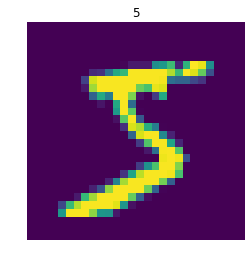

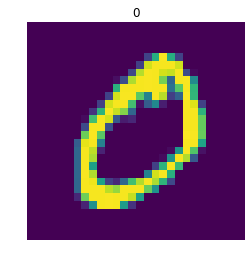

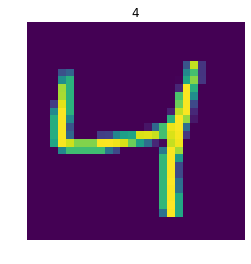

In [2]:
# helper function for later
def download(fname, drive_id):
    """Download a file from Google Drive.

    Adapted from https://stackoverflow.com/a/39225039/1306923
    """
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value
        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk:  # filter out keep-alive new chunks
                    f.write(chunk)

    if os.path.exists(fname):
        return
    if not has_requests:
        link = "https://drive.google.com/open?id=%s" % drive_id
        raise RuntimeError(
            "Cannot find '%s'. Download the file from\n  %s\n"
            "and place it in %s." % (fname, link, os.getcwd()))

    url = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(url, params={'id': drive_id}, stream=True)
    token = get_confirm_token(response)
    if token is not None:
        params = {'id': drive_id, 'confirm': token}
        response = session.get(url, params=params, stream=True)
    save_response_content(response, fname)


# load mnist dataset
if not os.path.exists('mnist.pkl.gz'):
    urlretrieve('http://deeplearning.net/data/mnist/mnist.pkl.gz',
                'mnist.pkl.gz')

with gzip.open('mnist.pkl.gz') as f:
    train_data, _, test_data = pickle.load(f, encoding="latin1")
train_data = list(train_data)
test_data = list(test_data)
for data in (train_data, test_data):
    one_hot = np.zeros((data[0].shape[0], 10))
    one_hot[np.arange(data[0].shape[0]), data[1]] = 1
    data[1] = one_hot

# plot some examples
for i in range(3):
    plt.figure()
    plt.imshow(np.reshape(train_data[0][i], (28, 28)))
    plt.axis('off')
    plt.title(str(np.argmax(train_data[1][i])));

#### Conv Layer

In [3]:
def conv_layer(x, *args, activation=True, **kwargs):
    # create a Conv2D transform with the given arguments
    conv = nengo.Convolution(*args, channels_last=False, **kwargs)

    if activation:
        # add an ensemble to implement the activation function
        layer = nengo.Ensemble(conv.output_shape.size, 1).neurons
    else:
        # no nonlinearity, so we just use a node
        layer = nengo.Node(size_in=conv.output_shape.size)

    # connect up the input object to the new layer
    nengo.Connection(x, layer, transform=conv)

    # print out the shape information for our new layer
    print("LAYER")
    print(conv.input_shape.shape, "->", conv.output_shape.shape)

    return layer, conv

#### Network Structure

In [5]:
dt = 0.001  # simulation timestep
presentation_time = 0.1  # input presentation time
max_rate = 100  # neuron firing rates
# neuron spike amplitude (scaled so that the overall output is ~1)
amp = 1 / max_rate
# input image shape
input_shape = (1, 28, 28)
n_parallel = 2  # number of parallel network repetitions

with nengo.Network(seed=0) as net:
    # set up the default parameters for ensembles/connections
    #nengo_loihi.add_params(net)
    net.config[nengo.Ensemble].neuron_type = (
        nengo.SpikingRectifiedLinear(amplitude=amp))
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([max_rate])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None

    # the input node that will be used to feed in input images
    inp = nengo.Node(
        nengo.processes.PresentInput(test_data[0], presentation_time),
        size_out=28 * 28)

    # the output node provides the 10-dimensional classification
    out = nengo.Node(size_in=10)

    # build parallel copies of the network
    for _ in range(n_parallel):
        layer, conv = conv_layer(
            inp, 1, input_shape, kernel_size=(1, 1),
            init=np.ones((1, 1, 1, 1)))
        # first layer is off-chip to translate the images into spikes
        #net.config[layer.ensemble].on_chip = False
        layer, conv = conv_layer(layer, 6, conv.output_shape,
                                 strides=(2, 2))
        layer, conv = conv_layer(layer, 24, conv.output_shape,
                                 strides=(2, 2))
        nengo.Connection(layer, out, transform=nengo_dl.dists.Glorot())

    out_p = nengo.Probe(out)
    out_p_filt = nengo.Probe(out, synapse=nengo.Alpha(0.01))

LAYER
(1, 28, 28) -> (1, 28, 28)
LAYER
(1, 28, 28) -> (6, 13, 13)
LAYER
(6, 13, 13) -> (24, 6, 6)
LAYER
(1, 28, 28) -> (1, 28, 28)
LAYER
(1, 28, 28) -> (6, 13, 13)
LAYER
(6, 13, 13) -> (24, 6, 6)


#### Optimize parameter 1

In [6]:
# set up training data
minibatch_size = 200
train_data = {inp: train_data[0][:, None, :],
              out_p: train_data[1][:, None, :]}

# for the test data evaluation we'll be running the network over time
# using spiking neurons, so we need to repeat the input/target data
# for a number of timesteps (based on the presentation_time)
test_data = {
    inp: np.tile(test_data[0][:, None, :],
                 (1, int(presentation_time / dt), 1)),
    out_p_filt: np.tile(test_data[1][:, None, :],
                        (1, int(presentation_time / dt), 1))
}

#### Error compute function

In [7]:
def crossentropy(outputs, targets):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
        logits=outputs, labels=targets))


def classification_error(outputs, targets):
    return 100 * tf.reduce_mean(
        tf.cast(tf.not_equal(tf.argmax(outputs[:, -1], axis=-1),
                             tf.argmax(targets[:, -1], axis=-1)),
                tf.float32))

#### Simulate
Create the NengoDL simulator and run the training using the sim.train function

##### More documents ...
More details on how to use NengoDL to optimize a model can be found here: https://www.nengo.ai/nengo-dl/training.html.

To speed up this example we can set do_training=False to load some pre-trained parameters. If you have the requests package installed, we will download these automatically. If not, download the following files to the directory containing this notebook.

- mnist_params.data-00000-of-00001
- mnist_params.index
- mnist_params.meta

In [10]:
## import requests module
try:
    import requests
    has_requests = True
except ImportError:
    has_requests = False

In [17]:
do_training = True #False

with nengo_dl.Simulator(net, minibatch_size=minibatch_size, seed=0) as sim:
    if do_training:
        print("error before training: %.2f%%" %
              sim.loss(test_data, {out_p_filt: classification_error}))

        # run training
        sim.train(train_data, tf.train.RMSPropOptimizer(learning_rate=0.001),
                  objective={out_p: crossentropy}, n_epochs=5)

        print("error after training: %.2f%%" %
              sim.loss(test_data, {out_p_filt: classification_error}))

        sim.save_params("./mnist_params")
    else:
        download("mnist_params.data-00000-of-00001",
                 "1BaNU7Er_Q3SJt4i4Eqbv1Ln_TkmmCXvy")
        download("mnist_params.index", "1w8GNylkamI-3yHfSe_L1-dBtvaQYjNlC")
        download("mnist_params.meta", "1JiaoxIqmRupT4reQ5BrstuILQeHNffrX")
        sim.load_params("./mnist_params")

    # store trained parameters back into the network
    sim.freeze_params(net)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
|         Constructing graph: creating base arrays (0%)        | ETA:  --:--:--

/home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/nengo_dl/simulator.py:131: UserWarning: No GPU support detected. It is recommended that you install tensorflow-gpu (`pip install tensorflow-gpu`).
  "No GPU support detected. It is recommended that you "


|             Constructing graph: build stage (0%)             | ETA:  --:--:--#########################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

/home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/nengo_dl/transform_builders.py:42: UserWarning: TensorFlow does not support convolution with channels_last=False on the CPU; inputs will be transformed to channels_last=True
  "to channels_last=True", UserWarning)


Construction finished in 0:00:00                                               
Calculation finished in 0:03:16                                                
error before training: 85.73%
|                   Training (0%)                  | ETA:  --:--:-- (loss: ---)WARNING:tensorflow:From /home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/ops/array_grad.py:425: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Training finished in 0:05:43 (loss: 0.0788)                                    
Calculation finished in 0:03:30                                                
error after training: 37.05%


#### Improve performance by adding synaptic filters to our trained network.

In [18]:
for conn in net.all_connections:
    conn.synapse = 0.005

if do_training:
    with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
        print("error w/ synapse: %.2f%%" %
              sim.loss(test_data, {out_p_filt: classification_error}))

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
|         Constructing graph: creating base arrays (0%)        | ETA:  --:--:--

/home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/nengo_dl/simulator.py:131: UserWarning: No GPU support detected. It is recommended that you install tensorflow-gpu (`pip install tensorflow-gpu`).
  "No GPU support detected. It is recommended that you "


|             Constructing graph: build stage (0%)             | ETA:  --:--:--#########################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

/home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/nengo_dl/transform_builders.py:42: UserWarning: TensorFlow does not support convolution with channels_last=False on the CPU; inputs will be transformed to channels_last=True
  "to channels_last=True", UserWarning)


Construction finished in 0:00:01                                               
Calculation finished in 0:04:59                                                
error w/ synapse: 2.79%


#### Test

In [20]:
n_presentations = 50
with nengo_dl.Simulator(net, dt=dt) as sim:
    # if running on Loihi, increase the max input spikes per step
    #if 'loihi' in sim.sims:
    #    sim.sims['loihi'].snip_max_spikes_per_step = 120

    # run the simulation on Loihi
    sim.run(n_presentations * presentation_time)

    # check classification error
    step = int(presentation_time / dt)
    output = sim.data[out_p_filt][step - 1::step]
    correct = 100 * (np.mean(
        np.argmax(output, axis=-1)
        != np.argmax(test_data[out_p_filt][:n_presentations, -1],
                     axis=-1)
    ))
    print("Error: %.2f%%" % correct)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
|#########Constructing graph: creating base arrays (700%)########################################################################################################################################################################################################################################################################################################################################################################################################| ETA: 0:00:00

/home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/nengo_dl/simulator.py:131: UserWarning: No GPU support detected. It is recommended that you install tensorflow-gpu (`pip install tensorflow-gpu`).
  "No GPU support detected. It is recommended that you "


|             Constructing graph: build stage (0%)             | ETA:  --:--:--##################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################| ETA: 0:00:00

/home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/nengo_dl/transform_builders.py:42: UserWarning: TensorFlow does not support convolution with channels_last=False on the CPU; inputs will be transformed to channels_last=True
  "to channels_last=True", UserWarning)


Construction finished in 0:00:01                                               
Simulation finished in 0:00:05                                                 
Error: 4.00%


#### Plotting

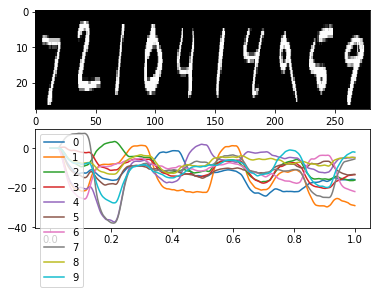

In [21]:
n_plots = 10
plt.figure()

plt.subplot(2, 1, 1)
images = test_data[inp].reshape(-1, 28, 28, 1)[::step]
ni, nj, nc = images[0].shape
allimage = np.zeros((ni, nj * n_plots, nc), dtype=images.dtype)
for i, image in enumerate(images[:n_plots]):
    allimage[:, i * nj:(i + 1) * nj] = image
if allimage.shape[-1] == 1:
    allimage = allimage[:, :, 0]
plt.imshow(allimage, aspect='auto', interpolation='none', cmap='gray')

plt.subplot(2, 1, 2)
plt.plot(sim.trange()[:n_plots * step], sim.data[out_p_filt][:n_plots * step])
plt.legend(['%d' % i for i in range(10)], loc='best');